### Findings
- It seems that the same model (parameters) can be used for different branches, without too much difference
- So far increasing the number of neurons yields better prediction
- Using time_steps of 7 seems to yields better prediction

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [51]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
input_file_dir_train = "/content/gdrive/MyDrive/Work/BCA/dataset/train"
input_file_dir_test = "/content/gdrive/MyDrive/Work/BCA/dataset/test"
model_output_dir = "/content/gdrive/MyDrive/Work/BCA/dataset/models"

In [53]:
os.listdir(input_file_dir_train)

['train_data_for_branch_64',
 'train_data_for_branch_14',
 'train_data_for_branch_21',
 'train_data_for_branch_8',
 'train_data_for_branch_1130']

In [54]:
train_data_for_branch = {}
for file in os.listdir(input_file_dir_train):
  branch = int(file.split("_")[-1])
  train_data_for_branch[branch] = pd.read_csv(f"{input_file_dir_train}/{file}", sep="|", header=0)
  train_data_for_branch[branch]["dt"] = pd.to_datetime(train_data_for_branch[branch]["dt"])
  train_data_for_branch[branch]["sumtrx"] = train_data_for_branch[branch]["sumtrx"].astype(np.int32)
  train_data_for_branch[branch] = train_data_for_branch[branch].set_index("dt")

test_data_for_branch = {}
for file in os.listdir(input_file_dir_test):
  branch = int(file.split("_")[-1])
  test_data_for_branch[branch] = pd.read_csv(f"{input_file_dir_test}/{file}", sep="|", header=0)
  test_data_for_branch[branch]["dt"] = pd.to_datetime(test_data_for_branch[branch]["dt"])
  test_data_for_branch[branch]["sumtrx"] = test_data_for_branch[branch]["sumtrx"].astype(np.int32)
  test_data_for_branch[branch] = test_data_for_branch[branch].set_index("dt")

In [55]:
# Membuat fungsi untuk mengubah data menjadi bentuk yang sesuai untuk LSTM
def create_dataset(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [56]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [57]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [58]:
# train
histories = {}
actual_vs_predicted = {}
for branch in list(train_data_for_branch):
  print(branch)
  # Mengubah data menjadi skala antara 0 dan 1
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_train_data = scaler.fit_transform(train_data_for_branch[branch].values.reshape(-1, 1))
  scaled_test_data = scaler.transform(test_data_for_branch[branch].values.reshape(-1, 1))
  # Menentukan jumlah time steps
  time_steps = 7

  # Membuat dataset latih dan uji
  X_train, y_train = create_dataset(scaled_train_data, time_steps)
  X_test, y_test = create_dataset(scaled_test_data, time_steps)

  # Reshape input menjadi bentuk yang sesuai untuk LSTM
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  # Membangun model LSTM
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(LSTM(60))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  # Melatih model
  with tf.device('/device:GPU:0'):
    histories[branch] = model.fit(X_train, y_train, epochs=5000, batch_size=32)
  # Melakukan prediksi
  predictions = model.predict(X_test)
  predictions = scaler.inverse_transform(predictions)

  actual_vs_predicted[branch] = pd.DataFrame(
      data={
          "Actual": test_data_for_branch[branch].iloc[:len(predictions), 0],
          "Predicted": predictions[:, 0].squeeze()
      }
  )

  model.save(f"{model_output_dir}/model_cabang_{branch}")



Output streaming akan dipotong hingga 5000 baris terakhir.
10/10 [==============================] - 0s 8ms/step - loss: 2.7058e-04
Epoch 2502/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.6259e-04
Epoch 2503/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.2099e-04
Epoch 2504/5000
10/10 [==============================] - 0s 8ms/step - loss: 9.1273e-05
Epoch 2505/5000
10/10 [==============================] - 0s 9ms/step - loss: 6.1120e-05
Epoch 2506/5000
10/10 [==============================] - 0s 7ms/step - loss: 5.6642e-05
Epoch 2507/5000
10/10 [==============================] - 0s 8ms/step - loss: 5.6002e-05
Epoch 2508/5000
10/10 [==============================] - 0s 8ms/step - loss: 5.4136e-05
Epoch 2509/5000
10/10 [==============================] - 0s 8ms/step - loss: 5.1184e-05
Epoch 2510/5000
10/10 [==============================] - 0s 9ms/step - loss: 5.8729e-05
Epoch 2511/5000
10/10 [==============================] - 0s 9ms/step - loss: 

3/3 [==============================] - 1s 5ms/step


Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 2502/5000
10/10 [==============================] - 0s 7ms/step - loss: 1.3692e-04
Epoch 2503/5000
10/10 [==============================] - 0s 7ms/step - loss: 1.8743e-04
Epoch 2504/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.6016e-04
Epoch 2505/5000
10/10 [==============================] - 0s 9ms/step - loss: 1.4765e-04
Epoch 2506/5000
10/10 [==============================] - 0s 7ms/step - loss: 1.1156e-04
Epoch 2507/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.0331e-04
Epoch 2508/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.5435e-04
Epoch 2509/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.3224e-04
Epoch 2510/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.2899e-04
Epoch 2511/5000
10/10 [==============================] - 0s 7ms/step - loss: 9.1303e-05
Epoch 2512/5000
10/10 [==============================] - 0s 7

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 2502/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.5375e-04
Epoch 2503/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.3747e-04
Epoch 2504/5000
10/10 [==============================] - 0s 9ms/step - loss: 4.0995e-04
Epoch 2505/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.5995e-04
Epoch 2506/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.0189e-04
Epoch 2507/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.0917e-04
Epoch 2508/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.5699e-04
Epoch 2509/5000
10/10 [==============================] - 0s 9ms/step - loss: 4.0795e-04
Epoch 2510/5000
10/10 [==============================] - 0s 9ms/step - loss: 4.3618e-04
Epoch 2511/5000
10/10 [==============================] - 0s 9ms/step - loss: 4.2456e-04
Epoch 2512/5000
10/10 [==============================] - 0s 1

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 2502/5000
10/10 [==============================] - 0s 9ms/step - loss: 3.0586e-05
Epoch 2503/5000
10/10 [==============================] - 0s 8ms/step - loss: 3.1380e-05
Epoch 2504/5000
10/10 [==============================] - 0s 8ms/step - loss: 2.7280e-05
Epoch 2505/5000
10/10 [==============================] - 0s 8ms/step - loss: 2.2811e-05
Epoch 2506/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.8298e-05
Epoch 2507/5000
10/10 [==============================] - 0s 8ms/step - loss: 2.1684e-05
Epoch 2508/5000
10/10 [==============================] - 0s 7ms/step - loss: 1.6637e-05
Epoch 2509/5000
10/10 [==============================] - 0s 7ms/step - loss: 1.3251e-05
Epoch 2510/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.6617e-05
Epoch 2511/5000
10/10 [==============================] - 0s 8ms/step - loss: 1.2677e-05
Epoch 2512/5000
10/10 [==============================] - 0s 8

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 2502/5000
10/10 [==============================] - 0s 10ms/step - loss: 5.8050e-05
Epoch 2503/5000
10/10 [==============================] - 0s 11ms/step - loss: 5.7449e-05
Epoch 2504/5000
10/10 [==============================] - 0s 10ms/step - loss: 4.9417e-05
Epoch 2505/5000
10/10 [==============================] - 0s 11ms/step - loss: 4.3693e-05
Epoch 2506/5000
10/10 [==============================] - 0s 8ms/step - loss: 4.1783e-05
Epoch 2507/5000
10/10 [==============================] - 0s 10ms/step - loss: 4.1364e-05
Epoch 2508/5000
10/10 [==============================] - 0s 10ms/step - loss: 6.0490e-05
Epoch 2509/5000
10/10 [==============================] - 0s 10ms/step - loss: 5.1393e-05
Epoch 2510/5000
10/10 [==============================] - 0s 10ms/step - loss: 6.8014e-05
Epoch 2511/5000
10/10 [==============================] - 0s 9ms/step - loss: 6.1717e-05
Epoch 2512/5000
10/10 [==============================

In [59]:
# temp_actual_vs_predicted = {}

# for branch in list(train_data_for_branch):
#   temp_actual_vs_predicted[branch] = pd.DataFrame(
#       data={
#           "Actual": test_data_for_branch[branch].iloc[:actual_vs_predicted[branch].shape[0], 0],
#           "Predicted": actual_vs_predicted[branch]["Predicted"]
#       }
#   )

In [60]:
# actual_vs_predicted = temp_actual_vs_predicted

In [61]:
from math import sqrt
from sklearn.metrics import mean_absolute_error

In [62]:
def calc_rmse(actual, predicted):
  rmse = sqrt(mean_squared_error(actual, predicted))
  return rmse

In [63]:
def calc_mae(actual, predicted):
  mae = mean_absolute_error(actual, predicted)
  return mae

In [64]:
def calc_smape(actual, predicted):
    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    smape_score = np.mean(numerator / denominator) * 100
    return smape_score

In [65]:
def evaluate(actual_vs_predicted):
  plt.figure(figsize=(18, 6))
  plt.plot(actual_vs_predicted.index, actual_vs_predicted["Actual"])
  plt.plot(actual_vs_predicted.index, actual_vs_predicted["Predicted"])

  # Mengatur label dan judul
  plt.xlabel('Date')
  plt.ylabel('sumtrx')
  plt.title('Actual vs Predicted')

  print("Root Mean Squared Error (RMSE):", calc_rmse(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"]))
  print("Mean Absolute Error (MAE):", calc_mae(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"]))
  print("SMAPE score:", calc_smape(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"]))

Root Mean Squared Error (RMSE): 5.729618233144522
Mean Absolute Error (MAE): 3.674357509825911
SMAPE score: 64.89087183881065


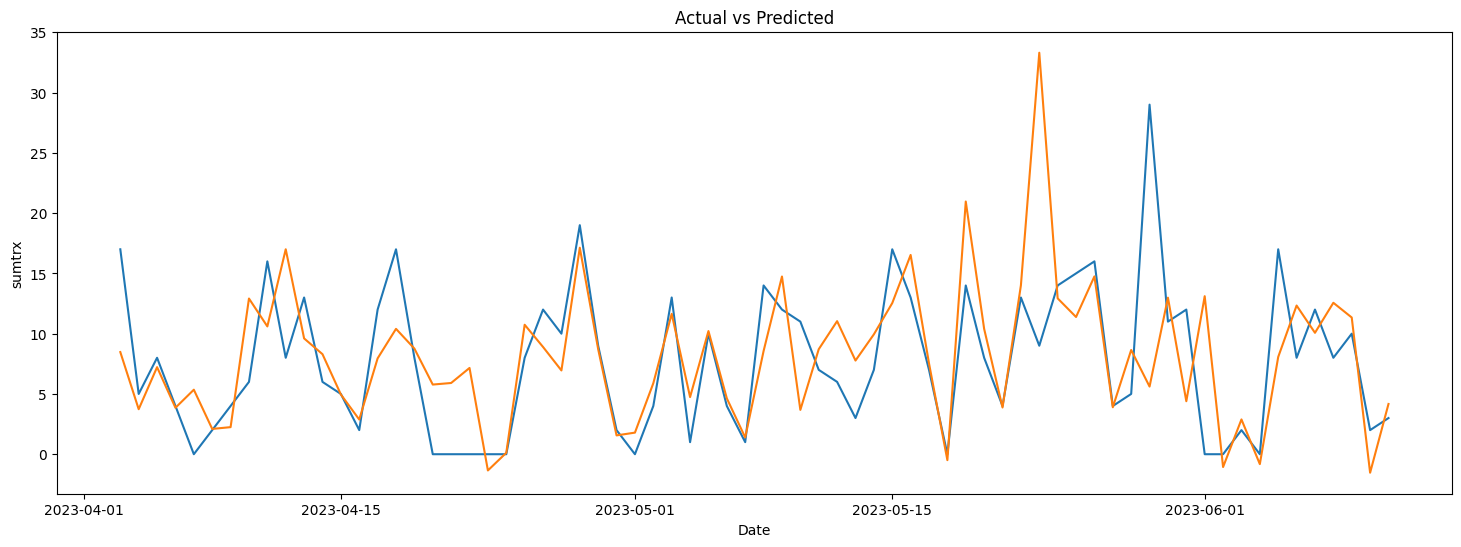

In [66]:
evaluate(actual_vs_predicted[1130])

Root Mean Squared Error (RMSE): 4.60914540082103
Mean Absolute Error (MAE): 3.2763359261410576
SMAPE score: 93.85717916230391


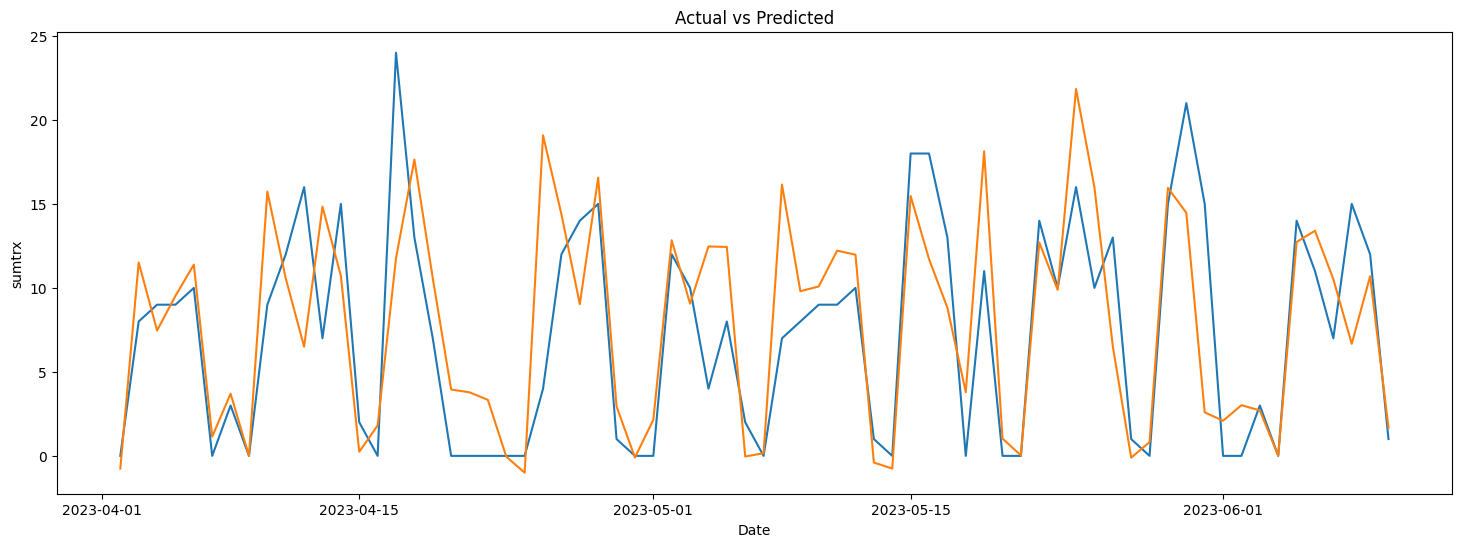

In [67]:
evaluate(actual_vs_predicted[14])

Root Mean Squared Error (RMSE): 11.264930971842984
Mean Absolute Error (MAE): 8.104742374164717
SMAPE score: 89.67425459110217


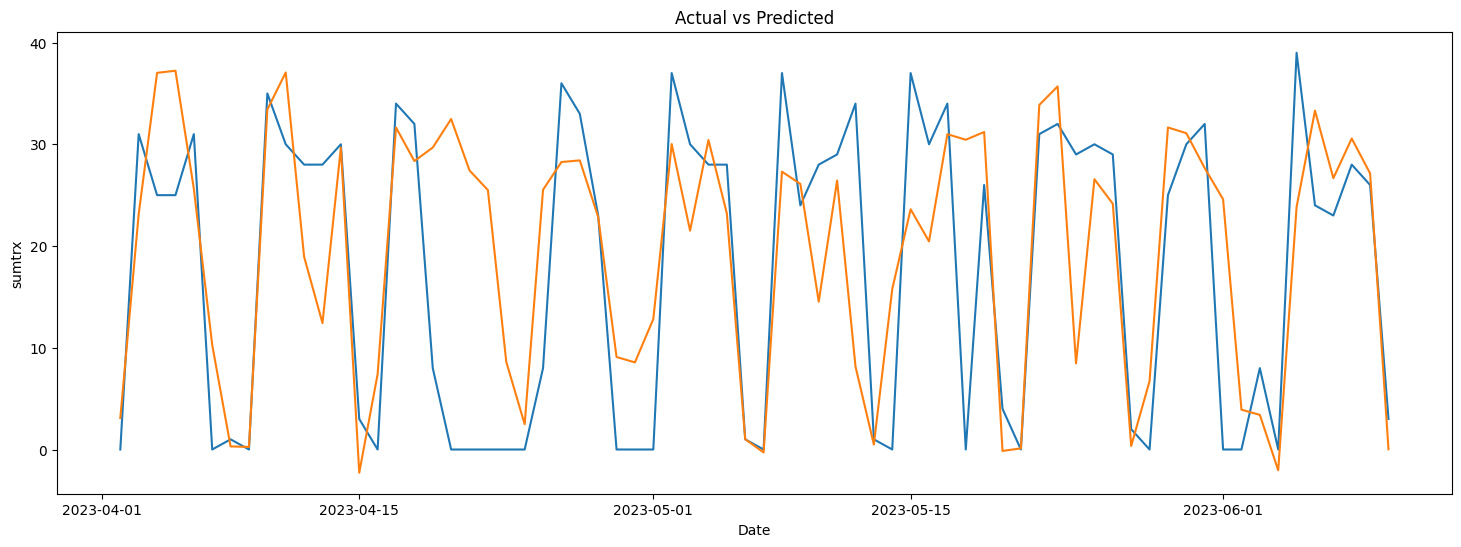

In [68]:
evaluate(actual_vs_predicted[21])

Root Mean Squared Error (RMSE): 4.0086731619652465
Mean Absolute Error (MAE): 2.6908938552158466
SMAPE score: 103.89743399817112


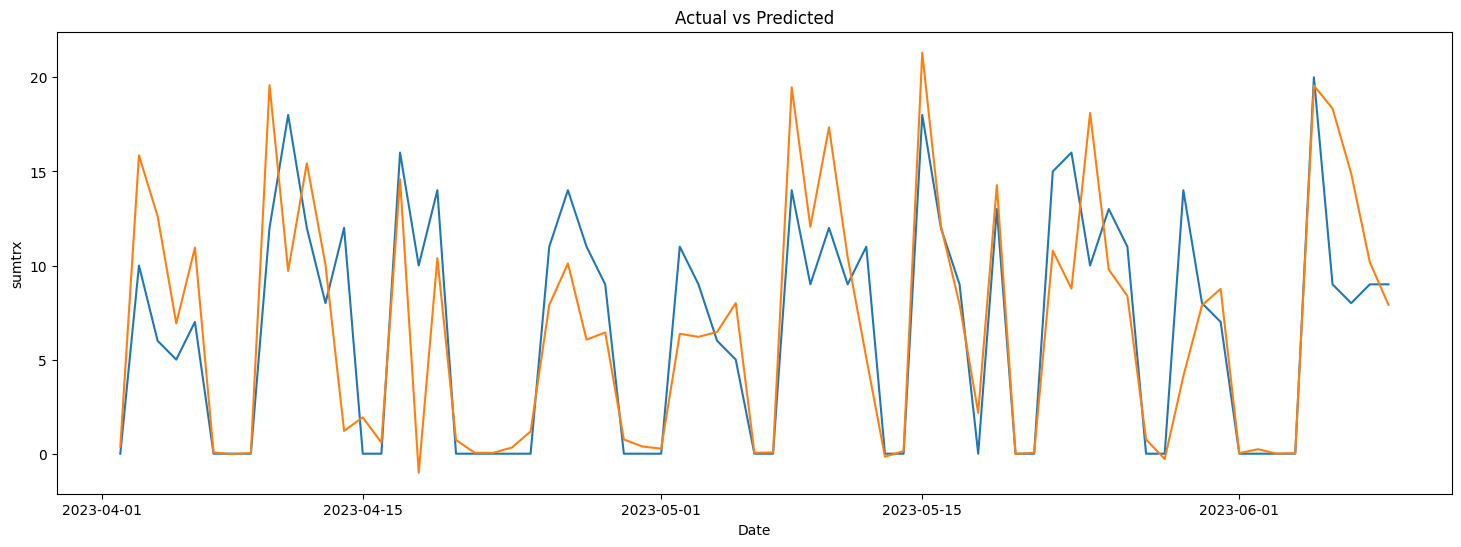

In [69]:
evaluate(actual_vs_predicted[64])

Root Mean Squared Error (RMSE): 4.549931111653527
Mean Absolute Error (MAE): 3.539350185223988
SMAPE score: 91.83912296904046


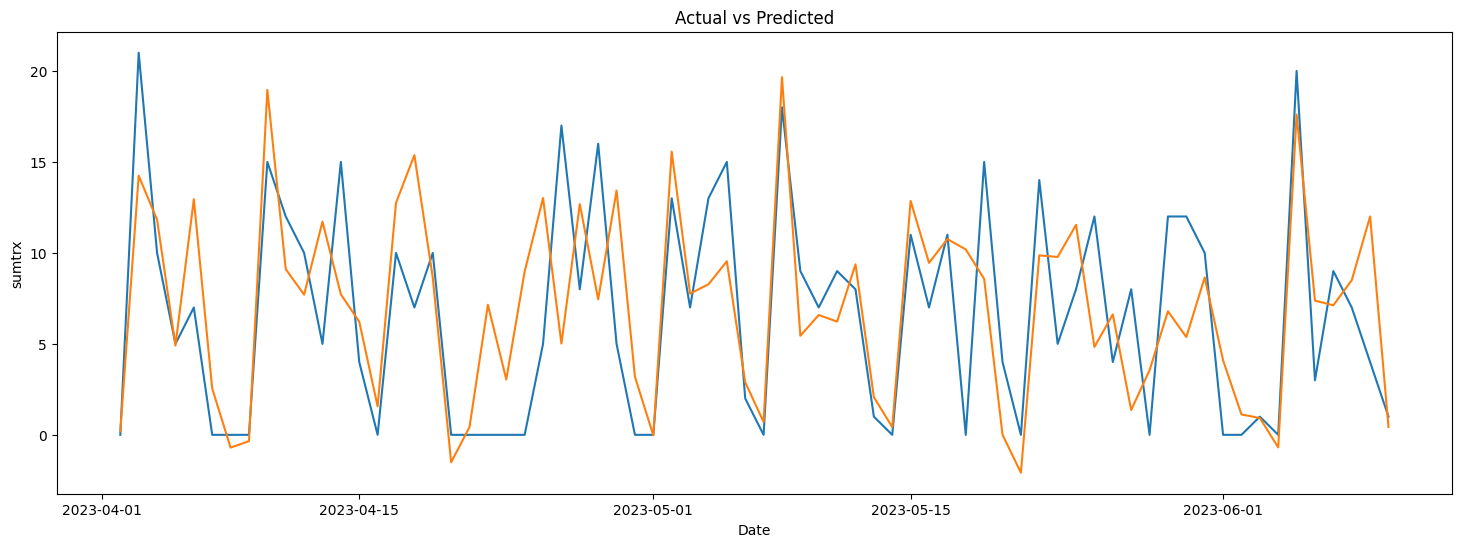

In [70]:
evaluate(actual_vs_predicted[8])